In [1]:
# imports + read data

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Paths ----
DATA_DIR = Path(r'C:\Users\moein\anaconda3\citi-bike-2022-weather\data\processed')
weather_path = DATA_DIR / "lga_weather_2022.csv"
trips_path   = DATA_DIR / "citibike_2022_all.csv"

# ---- Load weather ----
weather = pd.read_csv(weather_path)
# normalize column names
weather.columns = [c.strip().lower() for c in weather.columns]

# find/rename a temperature column to 'avg_temp'
for c in ["avgtemp","tavg","avg_temp","temp_avg","temperature","temp", "avg_temp_c"]:
    if c in weather.columns:
        weather = weather.rename(columns={c:"avg_temp"})
        break
if "avg_temp" not in weather.columns:
    raise KeyError("No temperature column found. Rename temperature column to something like 'avgTemp'/'tavg'.")

# parse 'date' column
if "date" not in weather.columns:
    raise KeyError("No 'date' column in weather. Add/rename date column to 'date'.")
weather["date"] = pd.to_datetime(weather["date"]).dt.normalize()

# keep only 2022 rows (safety)
weather = weather[weather["date"].dt.year == 2022].sort_values("date").reset_index(drop=True)

# ---- Load trips ----
trips = pd.read_csv(trips_path, low_memory=False)
trips.columns = [c.strip().lower() for c in trips.columns]

# find a datetime column and make a date
for start_col in ["started_at","start_time","starttime","start time","start_time_local","start_date"]:
    if start_col in trips.columns:
        trips["date"] = pd.to_datetime(trips[start_col], errors="coerce").dt.normalize()
        break
if "date" not in trips.columns:
    raise KeyError("Could not find a trips start-time column. Rename your start time to 'started_at' or similar.")

# keep 2022 only
trips = trips[trips["date"].dt.year == 2022].copy()

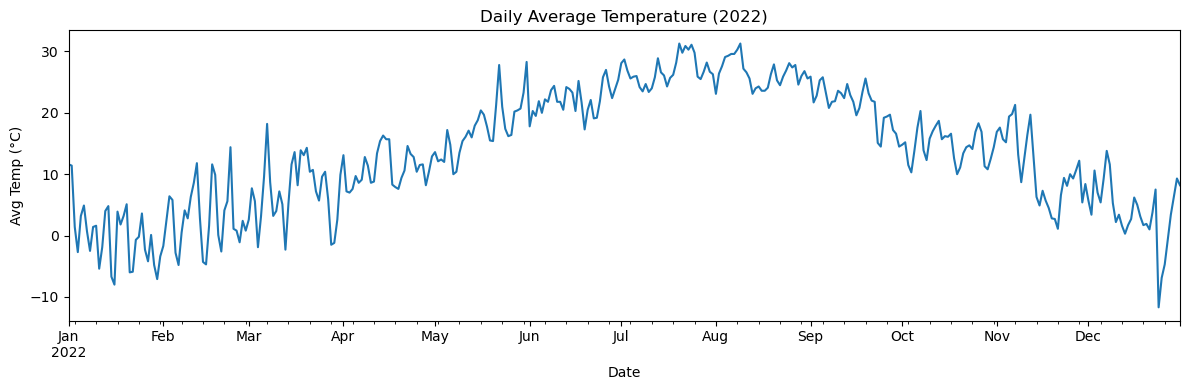

In [2]:
# Pandas quick plot: 2022 temperatures time series

_ = weather.set_index("date")["avg_temp"].plot(figsize=(12,4), title="Daily Average Temperature (2022)")
plt.xlabel("Date"); plt.ylabel("Avg Temp (°C)"); plt.tight_layout(); plt.show()

In [3]:
# Daily trip counts + merge with weather

# daily counts
daily_counts = (trips
                .groupby("date")
                .size()
                .rename("bike_rides_daily")
                .reset_index())

# outer join to keep all dates present in either frame
df_merged = (weather.merge(daily_counts, on="date", how="outer")
                     .sort_values("date")
                     .reset_index(drop=True))

# if needed, fill missing rides with 0
df_merged["bike_rides_daily"] = df_merged["bike_rides_daily"].fillna(0).astype(int)

# sanity checks
print(df_merged["date"].min(), df_merged["date"].max())
df_merged.head()

2022-01-01 00:00:00 2022-12-31 00:00:00


,date,avg_temp,bike_rides_daily
0,2022-01-01,11.6,592
1,2022-01-02,11.4,1248
2,2022-01-03,1.4,832
3,2022-01-04,-2.7,934
4,2022-01-05,3.2,914


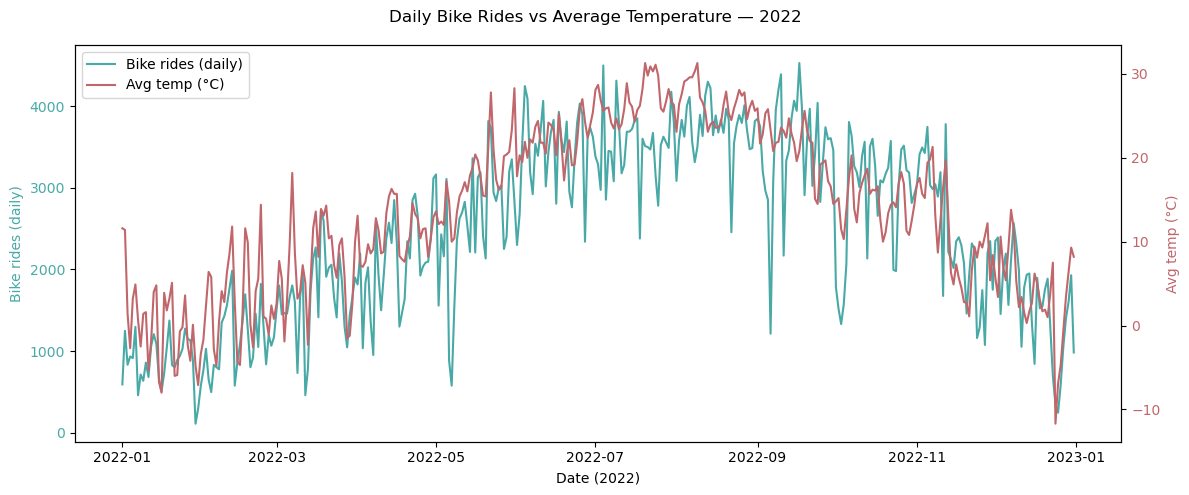

In [5]:
# Dual-axis line chart (bike trips vs temperature)

fig, ax = plt.subplots(figsize=(12,5))

# left y-axis: rides (#48A9A6)
l1 = ax.plot(df_merged["date"], 
             df_merged["bike_rides_daily"], 
             color="#48A9A6", 
             label="Bike rides (daily)")
ax.set_xlabel("Date (2022)")
ax.set_ylabel("Bike rides (daily)", color="#48A9A6")
ax.tick_params(axis="y", labelcolor="#48A9A6")

# right y-axis: temperature (#C1666B)
ax2 = ax.twinx()
l2 = ax2.plot(df_merged["date"], 
              df_merged["avg_temp"], 
              color="#C1666B", 
              label="Avg temp (°C)")
ax2.set_ylabel("Avg temp (°C)", color="#C1666B")
ax2.tick_params(axis="y", labelcolor="#C1666B")

# title + combined legend
fig.suptitle("Daily Bike Rides vs Average Temperature — 2022")
lines = l1 + l2
labels = [ln.get_label() for ln in lines]
ax.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()

### Explanation of Code

In this step, I created two types of plots using **Matplotlib**:

1. **Pandas Plot (Wrapper around Matplotlib)**  
   - For the quick exploratory plot of average daily temperatures, I used the built-in `.plot()` function from pandas.  
   - This provides a simple way to generate time series plots with minimal code.  

2. **Object-Oriented (OO) Matplotlib Plot**  
   - To compare daily bike rides with average temperatures, I switched to Matplotlib’s **object-oriented API**.  
   - I used `fig, ax = plt.subplots()` to define a figure and axes.  
   - Bike rides were plotted on the **left y-axis**, and temperatures were plotted on a **twin y-axis** using `ax.twinx()`.  
   - I customized the colors: bike rides are shown in **#48A9A6** and temperature in **#C1666B**.  
   - Finally, I added a combined legend, axis labels, and a title to make the visualization clear.  


In [10]:
### --- Bonus Task --- ###

In [6]:
# Inspect columns (after .lower() normalization)
print(trips.columns.tolist())

# Try common duration aliases (seconds or minutes)
DUR_ALIASES = [
    "tripduration","trip_duration","duration","duration_sec","duration_secs",
    "ride_length","ride_length_sec","ride_length_secs","tripduration_seconds",
    "elapsed_time","elapsed_seconds","ride_duration","ride_duration_sec"
]

DUR_COL = next((c for c in DUR_ALIASES if c in trips.columns), None)
print("Detected duration column:", DUR_COL)

# If no direct duration column, build it from start/end timestamps:
if DUR_COL is None:
    START_ALIASES = ["started_at","start_time","starttime","start time","start_time_local","start_date"]
    END_ALIASES   = ["ended_at","end_time","stoptime","stop time","end_time_local","end_date"]

    start_col = next((c for c in START_ALIASES if c in trips.columns), None)
    end_col   = next((c for c in END_ALIASES   if c in trips.columns), None)
    if not start_col or not end_col:
        raise KeyError("Could not find start/end time columns to compute duration.")

    t = trips.copy()
    t[start_col] = pd.to_datetime(t[start_col], errors="coerce")
    t[end_col]   = pd.to_datetime(t[end_col], errors="coerce")

    t["duration_sec"] = (t[end_col] - t[start_col]).dt.total_seconds()
    DUR_COL = "duration_sec"
    trips[DUR_COL] = t["duration_sec"]  # attach back to your frame
    print("Computed duration column:", DUR_COL)

['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_type', 'date']
Detected duration column: None
Computed duration column: duration_sec


In [7]:
# Heuristic: if median is large, assume seconds and convert to minutes
td_raw = pd.to_numeric(trips[DUR_COL], errors="coerce")

# keep only positive, non-missing
td_raw = td_raw[(td_raw > 0) & td_raw.notna()]

if td_raw.empty:
    raise KeyError("No valid positive durations to process.")

# If values look like seconds, convert (use scalar median)
td_med = td_raw.median()
assume_seconds = td_med > 100
td_min = (td_raw / 60.0) if assume_seconds else td_raw

# Trim extremes for readability
low, high = td_min.quantile([0.01, 0.99])
td_min = td_min.clip(lower = low, upper = high)

# attach back, alligned by index
trips.loc[td_min.index, "duration_min_clip"] = td_min

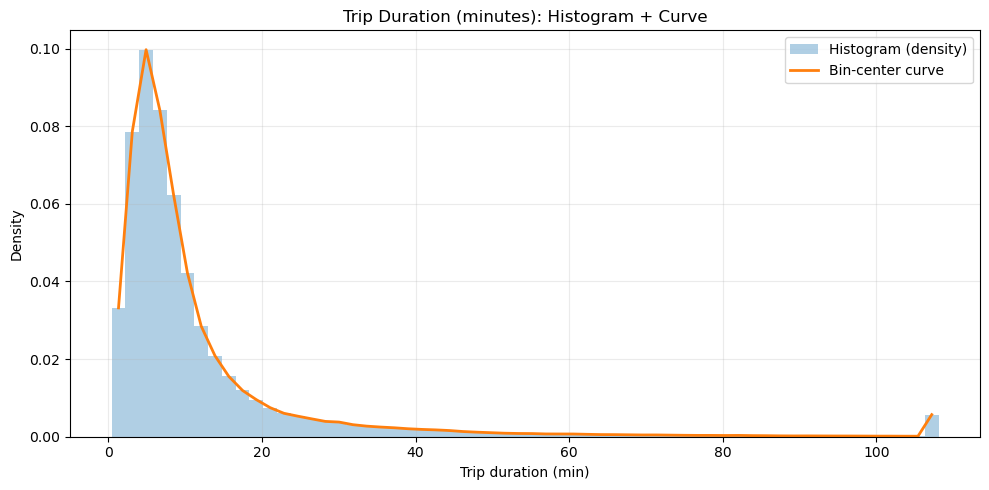

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
counts, bin_edges, _ = ax.hist(
    td_min, bins=60, density=True, alpha=0.35, edgecolor='none', label='Histogram (density)'
)
ax.set_title("Trip Duration (minutes): Histogram + Curve")
ax.set_xlabel("Trip duration (min)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.25)

# Curve through bin centers
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
ax.plot(bin_centers, counts, linewidth=2, label="Bin-center curve")

# Optional KDE if SciPy is available
try:
    from scipy.stats import gaussian_kde
    x = np.linspace(td_min.min(), td_min.max(), 400)
    ax.plot(x, gaussian_kde(td_min)(x), linestyle='--', linewidth=2, label="KDE")
except Exception:
    pass

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

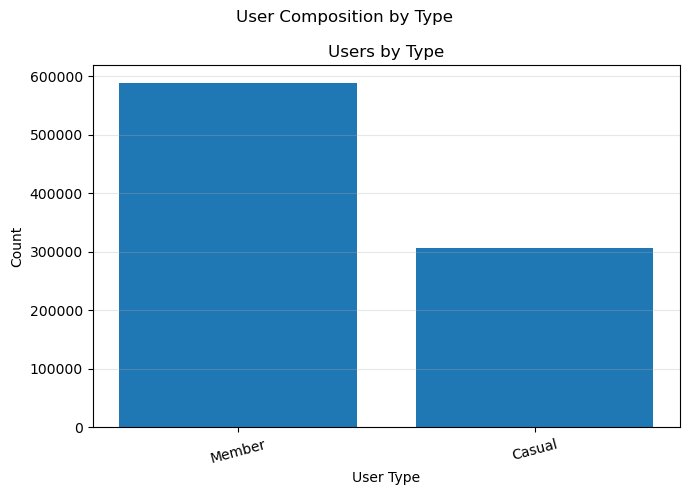

Note: No gender column detected; pie chart skipped.


In [10]:
# Figure with two axes (bar = usertype, pie = gender) using OO subplots

# 0) Ensure lowercase, trimmed columns
trips.columns = [c.strip().lower() for c in trips.columns]

# 1) Try exact alias matches first
USER_ALIASES   = ["usertype", "user_type", "member_casual", "customer_type", "membership_type", "plan", "passholder_type"]
GENDER_ALIASES = ["gender", "member_gender", "rider_gender", "sex"]

user_col   = next((c for c in USER_ALIASES   if c in trips.columns), None)
gender_col = next((c for c in GENDER_ALIASES if c in trips.columns), None)

# 2) If not found, detect by value patterns (member/casual/subscriber/customer)
if user_col is None:
    candidates = []
    target_tokens = {"member", "casual", "subscriber", "customer", "annual member"}
    for c in trips.columns:
        try:
            vals = (trips[c].dropna().astype(str).str.lower().str.strip().unique().tolist())
        except Exception:
            continue
        if any(tok in vals for tok in target_tokens):
            candidates.append(c)
    user_col = candidates[0] if candidates else None

if user_col is None:
    # last resort: show columns so you can pick one manually without crashing
    print("No user type column detected. Available columns:\n", trips.columns.tolist())
    # proceed without raising; we'll just skip the bar chart if still None

# 3) Normalize user types (if present)
if user_col is not None:
    user = (trips[user_col].astype("string").str.strip().str.lower())
    user_map = {
        "member": "Member", "subscriber": "Member", "annual member": "Member",
        "casual": "Casual", "customer": "Casual"
    }
    user = user.map(user_map).fillna(user.str.title())
    user = user.fillna("Unknown")
    vc_user = user.value_counts(dropna=False)
else:
    vc_user = None

# 4) Normalize gender (many Citi Bike 2022 sets simply don't have it)
if gender_col is not None:
    gender = (trips[gender_col].astype("string").str.strip().str.title().fillna("Unknown"))
    vc_gender = gender.value_counts(dropna=False)
else:
    vc_gender = None

# 5) Build subplots depending on what we actually have
if (vc_user is not None) and (vc_gender is not None):
    fig, (ax_bar, ax_pie) = plt.subplots(1, 2, figsize=(12,5))

    # Bar: user type
    ax_bar.bar(vc_user.index, vc_user.values)
    ax_bar.set_title("Users by Type")
    ax_bar.set_xlabel("User Type")
    ax_bar.set_ylabel("Count")
    ax_bar.grid(True, axis='y', alpha=0.3)
    ax_bar.tick_params(axis='x', rotation=15)

    # Pie: gender
    ax_pie.pie(vc_gender.values, labels=vc_gender.index,
               autopct='%1.1f%%', startangle=90, counterclock=False)
    ax_pie.set_title("Gender Share")
    ax_pie.axis('equal')

    fig.suptitle("User Composition by Type & Gender", y=0.98)
    plt.tight_layout()
    plt.show()

elif vc_user is not None:
    # Only user type available
    fig, ax_bar = plt.subplots(1, 1, figsize=(7,5))
    ax_bar.bar(vc_user.index, vc_user.values)
    ax_bar.set_title("Users by Type")
    ax_bar.set_xlabel("User Type")
    ax_bar.set_ylabel("Count")
    ax_bar.grid(True, axis='y', alpha=0.3)
    ax_bar.tick_params(axis='x', rotation=15)
    fig.suptitle("User Composition by Type", y=0.98)
    plt.tight_layout()
    plt.show()
    print("Note: No gender column detected; pie chart skipped.")
elif vc_gender is not None:
    # Only gender available
    fig, ax_pie = plt.subplots(1, 1, figsize=(6,6))
    ax_pie.pie(vc_gender.values, labels=vc_gender.index,
               autopct='%1.1f%%', startangle=90, counterclock=False)
    ax_pie.set_title("Gender Share")
    ax_pie.axis('equal')
    plt.tight_layout()
    plt.show()
    print("Note: No user type column detected; bar chart skipped.")
else:
    print("Neither user type nor gender columns were found. Please check your dataset headers.")